## 1: Data Preparation

##### 1.1: View dataset

In [0]:
display(spark.read.format('csv').option('header','true').load('/FileStore/tables/attribution_data.csv').limit(5))

uid,time,interaction,channel,conversion
00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11,impression,Instagram,0
00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07,impression,Online Display,0
00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46,impression,Online Display,0
00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51,impression,Online Display,0
0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57,impression,Paid Search,0


##### 1.2: Import libraries

In [0]:
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import *
import time

##### 1.3: Define schema and read the data into a dataframe

In [0]:
schema = StructType([StructField('uid', StringType(), True),
StructField('time', TimestampType(), True),
StructField('interaction', StringType(), True),
StructField('channel', StringType(), True),
StructField('conversion', IntegerType(), True)])

In [0]:
raw_data_df = spark.read.format("csv") \
            .option("header", "true") \
            .schema(schema) \
            .load('/FileStore/tables/attribution_data.csv')

In [0]:
display(raw_data_df.limit(5))

uid,time,interaction,channel,conversion
00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11.000+0000,impression,Instagram,0
00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07.000+0000,impression,Online Display,0
00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46.000+0000,impression,Online Display,0
00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51.000+0000,impression,Online Display,0
0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57.000+0000,impression,Paid Search,0


##### 1.4: Write Data to Delta Lake

In [0]:
bronze_tbl_path = '/FileStore/tables/bronzetable'

In [0]:
raw_data_df.write.format("delta") \
  .option("checkpointLocation", bronze_tbl_path+"/checkpoint") \
  .save(bronze_tbl_path)

##### 1.5: Create Database

In [0]:
database_name = "MultitouchAttribution"
# Delete the old database and tables if needed
_ = spark.sql('DROP DATABASE IF EXISTS {} CASCADE'.format(database_name))

# Create database to house tables
_ = spark.sql('CREATE DATABASE {}'.format(database_name))

##### 1.6: Create bronze-level table in Delta format

In [0]:
# Create bronze table
_ = spark.sql('''
  CREATE TABLE `{}`.bronze
  USING DELTA 
  LOCATION '{}'
  '''.format(database_name,bronze_tbl_path))

##### 1.7: View the bronze table

In [0]:
bronze_tbl = spark.table("{}.bronze".format(database_name))

In [0]:
display(bronze_tbl.limit(5))

uid,time,interaction,channel,conversion
00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11.000+0000,impression,Instagram,0
00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07.000+0000,impression,Online Display,0
00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46.000+0000,impression,Online Display,0
00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51.000+0000,impression,Online Display,0
0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57.000+0000,impression,Paid Search,0


##### 1.8: Set the current database so that it doesn't need to be manually specified each time it's used.

In [0]:
_ = spark.sql("use {}".format(database_name))

##### 1.9: Create a user journey temporary view

In [0]:
%sql 
CREATE OR REPLACE TEMP VIEW user_journey_view AS
SELECT
  sub2.uid AS uid,CASE
    WHEN sub2.conversion == 1 then concat('Start > ', sub2.path, ' > Conversion')
    ELSE concat('Start > ', sub2.path, ' > Null')
  END AS path,
  sub2.first_interaction AS first_interaction,
  sub2.last_interaction AS last_interaction,
  sub2.conversion AS conversion,
  sub2.visiting_order AS visiting_order
FROM
  (
    SELECT
      sub.uid AS uid,
      concat_ws(' > ', collect_list(sub.channel)) AS path,
      element_at(collect_list(sub.channel), 1) AS first_interaction,
      element_at(collect_list(sub.channel), -1) AS last_interaction,
      element_at(collect_list(sub.conversion), -1) AS conversion,
      collect_list(sub.visit_order) AS visiting_order
    FROM
      (
        SELECT
          uid,
          channel,
          time,
          conversion,
          dense_rank() OVER (
            PARTITION BY uid
            ORDER BY
              time asc
          ) as visit_order
        FROM
          bronze
      ) AS sub
    GROUP BY
      sub.uid
  ) AS sub2;

##### 1.10: View the user journey data

In [0]:
%sql
SELECT * FROM user_journey_view
limit(5)

uid,path,first_interaction,last_interaction,conversion,visiting_order
000Afi9i930kBkA9EhBDDi9B7,Start > Online Video > Online Video > Online Video > Online Video > Online Video > Online Video > Online Video > Null,Online Video,Online Video,0,"List(1, 2, 3, 4, 5, 6, 7)"
000BA9hECi3BiBkAifAA7ifA7,Start > Facebook > Null,Facebook,Facebook,0,List(1)
000fCfBEk7Ci39iDAn07A3inE,Start > Instagram > Null,Instagram,Instagram,0,List(1)
0030F0fDEkoDBi3hE0hnfBBiC,Start > Facebook > Facebook > Facebook > Facebook > Instagram > Instagram > Facebook > Facebook > Instagram > Null,Facebook,Instagram,0,"List(1, 2, 3, 4, 5, 6, 7, 8, 9)"
0037773AB7kDkEBoCE9hFDonB,Start > Online Video > Online Video > Null,Online Video,Online Video,0,"List(1, 2)"


##### 1.11: Create and view the gold_user_journey table

In [0]:
gold_user_journey_tbl_path = '/FileStore/tables/golduserjourneytable'

In [0]:
_ = spark.sql('''
  CREATE TABLE IF NOT EXISTS `{}`.gold_user_journey
  USING DELTA 
  LOCATION '{}'
  AS SELECT * from user_journey_view
  '''.format(database_name, gold_user_journey_tbl_path))

In [0]:
%sql
select * from gold_user_journey
limit (5)

uid,path,first_interaction,last_interaction,conversion,visiting_order
000Afi9i930kBkA9EhBDDi9B7,Start > Online Video > Online Video > Online Video > Online Video > Online Video > Online Video > Online Video > Null,Online Video,Online Video,0,"List(1, 2, 3, 4, 5, 6, 7)"
000BA9hECi3BiBkAifAA7ifA7,Start > Facebook > Null,Facebook,Facebook,0,List(1)
000fCfBEk7Ci39iDAn07A3inE,Start > Instagram > Null,Instagram,Instagram,0,List(1)
0030F0fDEkoDBi3hE0hnfBBiC,Start > Facebook > Facebook > Facebook > Facebook > Instagram > Instagram > Facebook > Facebook > Instagram > Null,Facebook,Instagram,0,"List(1, 2, 3, 4, 5, 6, 7, 8, 9)"
0037773AB7kDkEBoCE9hFDonB,Start > Online Video > Online Video > Null,Online Video,Online Video,0,"List(1, 2)"


##### 1.12: Optimize the gold_user_journey table

In [0]:
%sql 
OPTIMIZE gold_user_journey ZORDER BY uid

path,metrics
dbfs:/FileStore/tables/golduserjourneytable,"List(1, 8, List(7564177, 7564177, 7564177.0, 1, 7564177), List(866347, 997939, 900422.875, 8, 7203383), 0, List(minCubeSize(107374182400), List(0, 0), List(8, 7203383), 0, List(8, 7203383), 1, null), 1, 8, 0, false)"


##### 1.13: Create temporary view for first-touch and last-touch attribution metrics

In [0]:
%sql 
CREATE OR REPLACE TEMP VIEW attribution_view AS
SELECT
  'first_touch' AS attribution_model,
  first_interaction AS channel,
  round(count(*) / (
     SELECT COUNT(*)
     FROM gold_user_journey
     WHERE conversion = 1),2) AS attribution_percent
FROM gold_user_journey
WHERE conversion = 1
GROUP BY first_interaction
UNION
SELECT
  'last_touch' AS attribution_model,
  last_interaction AS channel,
  round(count(*) /(
      SELECT COUNT(*)
      FROM gold_user_journey
      WHERE conversion = 1),2) AS attribution_percent
FROM gold_user_journey
WHERE conversion = 1
GROUP BY last_interaction

##### 1.14: Use the temporary view to create the gold_attribution table

In [0]:
gold_attribution_tbl_path = '/FileStore/tables/goldattributiontable'

In [0]:
_ = spark.sql('''
CREATE TABLE IF NOT EXISTS gold_attribution
USING DELTA
LOCATION '{}'
AS
SELECT * FROM attribution_view'''.format(gold_attribution_tbl_path))

In [0]:
%sql
SELECT * FROM gold_attribution

attribution_model,channel,attribution_percent
first_touch,Online Video,0.18
first_touch,Instagram,0.13
first_touch,Paid Search,0.27
first_touch,Online Display,0.12
first_touch,Facebook,0.29
last_touch,Paid Search,0.26
last_touch,Instagram,0.13
last_touch,Online Video,0.19
last_touch,Facebook,0.3
last_touch,Online Display,0.12


##### 1.15: Import libraries

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

##### 1.16: Use the gold_attribution table to view first touch vs. last touch by channel

Out[22]: <seaborn.axisgrid.FacetGrid at 0x7f7635bc8a30>

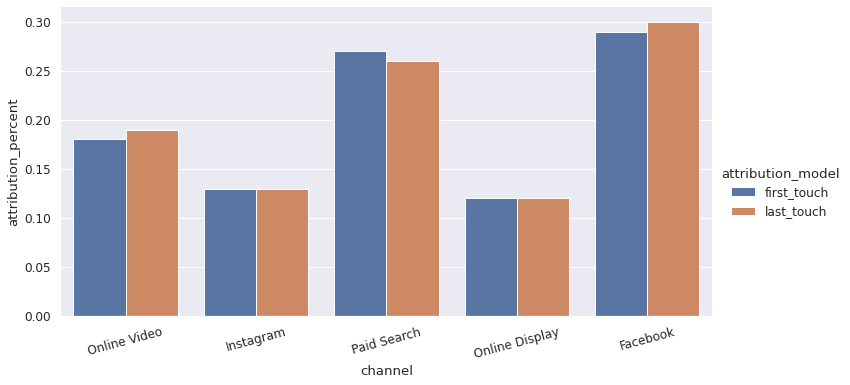

In [0]:
attribution_pd = spark.table('gold_attribution').toPandas()

sns.set(font_scale=1.1)
sns.catplot(x='channel',y='attribution_percent',hue='attribution_model',data=attribution_pd, kind='bar', aspect=2).set_xticklabels(rotation=15)

## 2: Production

##### Check 1: Upsert data into the gold_user_journey table

In [0]:
%sql
MERGE INTO gold_user_journey
USING user_journey_view
ON user_journey_view.uid = gold_user_journey.uid
WHEN MATCHED THEN
  UPDATE SET *
WHEN NOT MATCHED
  THEN INSERT *

num_affected_rows,num_updated_rows,num_deleted_rows,num_inserted_rows
240108,240108,0,0


##### Check 2: Propogate updates made to the gold_user_journey table to the gold_attribution table

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW attribution_view AS
SELECT 'first_touch' AS attribution_model, first_interaction AS channel, 
        round(count(*)/(SELECT COUNT(*) FROM gold_user_journey WHERE conversion =1), 2)AS attribution_percent 
FROM gold_user_journey 
WHERE conversion =1 
GROUP BY first_interaction
UNION
SELECT 'last_touch' AS attribution_model, last_interaction AS channel, 
        round(count(*)/(SELECT COUNT(*) FROM gold_user_journey WHERE conversion =1), 2)AS attribution_percent 
FROM gold_user_journey 
WHERE conversion =1 
GROUP BY last_interaction

In [0]:
%sql
MERGE INTO gold_attribution
USING attribution_view
ON attribution_view.attribution_model = gold_attribution.attribution_model AND attribution_view.channel = gold_attribution.channel
WHEN MATCHED THEN
  UPDATE SET *
WHEN NOT MATCHED
  THEN INSERT *

num_affected_rows,num_updated_rows,num_deleted_rows,num_inserted_rows
10,10,0,0


##### Check 3: Review Delta Lake table history for auditing & governance

In [0]:
%sql
describe history gold_user_journey

version,timestamp,userId,userName,operation,operationParameters,job,notebook,clusterId,readVersion,isolationLevel,isBlindAppend,operationMetrics,userMetadata,engineInfo
2,2022-10-28T19:14:13.000+0000,5466636154867902,muhammadaqibjamil@gmail.com,MERGE,"Map(predicate -> (user_journey_view.uid = spark_catalog.multitouchattribution.gold_user_journey.uid), matchedPredicates -> [{""actionType"":""update""}], notMatchedPredicates -> [{""actionType"":""insert""}])",null,List(4359080051219380),1028-190047-8qew1ybs,1,WriteSerializable,false,"Map(numTargetRowsCopied -> 0, numTargetRowsDeleted -> 0, numTargetFilesAdded -> 8, executionTimeMs -> 31162, numTargetRowsInserted -> 0, scanTimeMs -> 18231, numTargetRowsUpdated -> 240108, numOutputRows -> 240108, numTargetChangeFilesAdded -> 0, numSourceRows -> 240108, numTargetFilesRemoved -> 1, rewriteTimeMs -> 7510)",null,Databricks-Runtime/10.4.x-scala2.12
1,2022-10-28T19:13:17.000+0000,5466636154867902,muhammadaqibjamil@gmail.com,OPTIMIZE,"Map(predicate -> [], zOrderBy -> [""uid""], batchId -> 0, auto -> false)",null,List(4359080051219380),1028-190047-8qew1ybs,0,SnapshotIsolation,false,"Map(numRemovedFiles -> 8, numRemovedBytes -> 7203383, p25FileSize -> 7564177, minFileSize -> 7564177, numAddedFiles -> 1, maxFileSize -> 7564177, p75FileSize -> 7564177, p50FileSize -> 7564177, numAddedBytes -> 7564177)",null,Databricks-Runtime/10.4.x-scala2.12
0,2022-10-28T19:12:53.000+0000,5466636154867902,muhammadaqibjamil@gmail.com,CREATE TABLE AS SELECT,"Map(isManaged -> false, description -> null, partitionBy -> [], properties -> {})",null,List(4359080051219380),1028-190047-8qew1ybs,null,WriteSerializable,true,"Map(numFiles -> 8, numOutputRows -> 240108, numOutputBytes -> 7203383)",null,Databricks-Runtime/10.4.x-scala2.12


## 3: Multi-Touch Attribution with Markov Chains

##### 3.1: Import libraries

In [0]:
from pyspark.sql.types import StringType, ArrayType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

##### 3.2: Define a user-defined function (UDF) that takes a customer journey and enumerates each of the corresponding channel transitions

In [0]:
 def get_transition_array(path):
  '''
    This function takes as input a user journey (string) where each state transition is marked by a >. 
    The output is an array that has an entry for each individual state transition.
  '''
  state_transition_array = path.split(">")
  initial_state = state_transition_array[0]
  
  state_transitions = []
  for state in state_transition_array[1:]:
    state_transitions.append(initial_state.strip()+' > '+state.strip())
    initial_state =  state
  
  return state_transitions

##### 3.3: Register the `get_transition_array` udf as a Spark UDF so that it can be utilized in Spark SQL

In [0]:
spark.udf.register("get_transition_array", get_transition_array, ArrayType(StringType()))

Out[25]: <function __main__.get_transition_array(path)>

##### 3.4: Use the `get_transition_array` to enumerate all channel transitions in a customer's journey

In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW markov_state_transitions AS
SELECT path,
  explode(get_transition_array(path)) as transition,
  1 AS cnt
FROM
  gold_user_journey

In [0]:
%sql
select * from markov_state_transitions
limit(5)

path,transition,cnt
Start > Online Video > Online Video > Online Video > Facebook > Instagram > Null,Start > Online Video,1
Start > Online Video > Online Video > Online Video > Facebook > Instagram > Null,Online Video > Online Video,1
Start > Online Video > Online Video > Online Video > Facebook > Instagram > Null,Online Video > Online Video,1
Start > Online Video > Online Video > Online Video > Facebook > Instagram > Null,Online Video > Facebook,1
Start > Online Video > Online Video > Online Video > Facebook > Instagram > Null,Facebook > Instagram,1


##### 3.5: Construct the transition probability matrix

In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW transition_matrix AS
SELECT
  left_table.start_state,
  left_table.end_state,
  left_table.total_transitions / right_table.total_state_transitions_initiated_from_start_state AS transition_probability
FROM
  (
    SELECT
      transition,
      sum(cnt) total_transitions,
      trim(SPLIT(transition, '>') [0]) start_state,
      trim(SPLIT(transition, '>') [1]) end_state
    FROM
      markov_state_transitions
    GROUP BY
      transition
    ORDER BY
      transition
  ) left_table
  JOIN (
    SELECT
      a.start_state,
      sum(a.cnt) total_state_transitions_initiated_from_start_state
    FROM
      (
        SELECT
          trim(SPLIT(transition, '>') [0]) start_state,
          cnt
        FROM
          markov_state_transitions
      ) AS a
    GROUP BY
      a.start_state
  ) right_table ON left_table.start_state = right_table.start_state
ORDER BY
  end_state DESC

##### 3.6: Validate that the state transition probabilities are calculated correctly

In [0]:
%sql 
SELECT start_state, round(sum(transition_probability),2) as transition_probability_sum 
FROM transition_matrix
GROUP BY start_state

start_state,transition_probability_sum
Online Display,1.0
Instagram,1.0
Start,1.0
Paid Search,1.0
Online Video,1.0
Facebook,1.0


##### 3.7: Display the transition probability matrix

Out[26]: <AxesSubplot:xlabel='end_state', ylabel='start_state'>

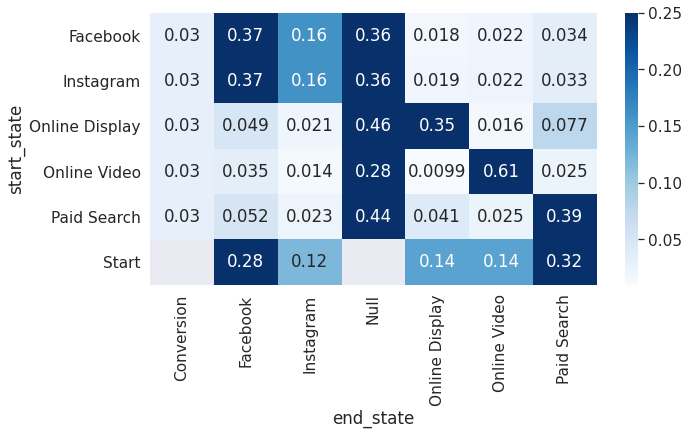

In [0]:
transition_matrix_pd = spark.table('transition_matrix').toPandas()
transition_matrix_pivot = transition_matrix_pd.pivot(index='start_state',columns='end_state',values='transition_probability')

plt.figure(figsize=(10,5))
sns.set(font_scale=1.4)
sns.heatmap(transition_matrix_pivot,cmap='Blues',vmax=0.25,annot=True)

##### 3.8: Define `get_transition_probability_graph` utility function

In [0]:
def get_transition_probability_graph(removal_state = "null"):
  '''
  This function calculates a subset of the transition probability graph based on the state to exclude
      removal_state: channel that we want to exclude from our Transition Probability Matrix
  returns subset of the Transition Probability matrix as pandas Dataframe
  '''
  
  transition_probability_pandas_df = None
  
  # Get the transition probability graph without any states excluded if the removal_state is null
  if removal_state == "null":
    transition_probability_pandas_df = spark.sql('''select
        trim(start_state) as start_state,
        collect_list(end_state) as next_stages,
        collect_list(transition_probability) as next_stage_transition_probabilities
      from
        transition_matrix
      group by
        start_state''').toPandas()
    
  # Otherwise, get the transition probability graph with the specified channel excluded/removed
  else:
    transition_probability_pandas_df = spark.sql('''select
      sub1.start_state as start_state,
      collect_list(sub1.end_state) as next_stages,
      collect_list(transition_probability) as next_stage_transition_probabilities
      from
      (
        select
          trim(start_state) as start_state,
          case
            when end_state == \"'''+removal_state+'''\" then 'Null'
            else end_state
          end as end_state,
          transition_probability
        from
          transition_matrix
        where
          start_state != \"'''+removal_state+'''\"
      ) sub1 group by sub1.start_state''').toPandas()

  return transition_probability_pandas_df

In [0]:
transition_probability_pandas_df = get_transition_probability_graph()

In [0]:
transition_probability_pandas_df

,start_state,next_stages,next_stage_transition_probabilities
0,Online Display,"[Paid Search, Online Video, Online Display, Nu...","[0.07735071003335538, 0.01645250728329557, 0.3..."
1,Instagram,"[Paid Search, Online Video, Online Display, Nu...","[0.033350620337495515, 0.022247044587173043, 0..."
2,Start,"[Paid Search, Online Video, Online Display, In...","[0.31739883718993117, 0.14236093757808985, 0.1..."
3,Paid Search,"[Paid Search, Online Video, Online Display, Nu...","[0.38598124669836237, 0.024735868991019545, 0...."
4,Online Video,"[Paid Search, Online Video, Online Display, Nu...","[0.024677410813577872, 0.6060616758750949, 0.0..."
5,Facebook,"[Paid Search, Online Video, Online Display, Nu...","[0.034010276486420354, 0.021986901178438725, 0..."


##### 3.9: Define `calculate_conversion_probability` utility function

In [0]:
def calculate_conversion_probability(transition_probability_pandas_df, calculated_state_conversion_probabilities, visited_states, current_state="Start"):
  '''
  This function calculates total conversion probability based on a subset of the transition probability graph
    transition_probability_pandas_df: This is a Dataframe that maps the current state to all probable next stages along with their transition probability
    removal_state: the channel that we want to exclude from our Transition Probability Matrix
    visited_states: set that keeps track of the states that have been visited thus far in our state transition graph.
    current_state: by default the start state for the state transition graph is Start state
  returns conversion probability of current state/channel 
  '''
 
  #If the customer journey ends with conversion return 1
  if current_state=="Conversion":
    return 1.0
  
  #If the customer journey ends without conversion, or if we land on the same state again, return 0.
  #Note: this step will mitigate looping on a state in the event that a customer path contains a transition from a channel to that same channel.
  elif (current_state=="Null") or (current_state in visited_states):
    return 0.0
  
  #Get the conversion probability of the state if its already calculated
  elif current_state in calculated_state_conversion_probabilities.keys():
    return calculated_state_conversion_probabilities[current_state]
  
  else:
  #Calculate the conversion probability of the new current state
    #Add current_state to visited_states
    visited_states.add(current_state)
    
    #Get all of the transition probabilities from the current state to all of the possible next states
    current_state_transition_df = transition_probability_pandas_df.loc[transition_probability_pandas_df.start_state==current_state]
    
    #Get the next states and the corresponding transition probabilities as a list.
    next_states = current_state_transition_df.next_stages.to_list()[0]
    next_states_transition_probab = current_state_transition_df.next_stage_transition_probabilities.to_list()[0]
    
    #This will hold the total conversion probability of each of the states that are candidates to be visited next from the current state.
    current_state_conversion_probability_arr = []
    
    #Call this function recursively until all states in next_states have been incorporated into the total conversion probability
    import copy
    #Loop over the list of next states and their transition probabilities recursively
    for next_state, next_state_tx_probability in zip(next_states, next_states_transition_probab):
      current_state_conversion_probability_arr.append(next_state_tx_probability * calculate_conversion_probability(transition_probability_pandas_df, calculated_state_conversion_probabilities, copy.deepcopy(visited_states), next_state))
    
    #Sum the total conversion probabilities we calculated above to get the conversion probability of the current state.
    #Add the conversion probability of the current state to our calculated_state_conversion_probabilities dictionary.
    calculated_state_conversion_probabilities[current_state] =  sum(current_state_conversion_probability_arr)
    
    #Return the calculated conversion probability of the current state.
    return calculated_state_conversion_probabilities[current_state]

##### 3.10: Calculate the total conversion probability

In [0]:
total_conversion_probability = calculate_conversion_probability(transition_probability_pandas_df, {}, visited_states=set(), current_state="Start")

In [0]:
total_conversion_probability

Out[32]: 0.03348629943630982

##### 3.11: Calculate the removal effect per channel

In [0]:
removal_effect_per_channel = {}
for channel in transition_probability_pandas_df.start_state.to_list():
  if channel!="Start":
    transition_probability_subset_pandas_df = get_transition_probability_graph(removal_state=channel)
    new_conversion_probability =  calculate_conversion_probability(transition_probability_subset_pandas_df, {}, visited_states=set(), current_state="Start")
    removal_effect_per_channel[channel] = round(((total_conversion_probability-new_conversion_probability)/total_conversion_probability), 2)

##### 3.12: Calculate conversion attribution per channel

In [0]:
conversion_attribution={}

for channel in removal_effect_per_channel.keys():
  conversion_attribution[channel] = round(removal_effect_per_channel[channel] / sum(removal_effect_per_channel.values()), 2)

channels = list(conversion_attribution.keys())
conversions = list(conversion_attribution.values())

conversion_pandas_df= pd.DataFrame({'attribution_model': 
                                    ['markov_chain' for _ in range(len(channels))], 
                                    'channel':channels, 
                                    'attribution_percent': conversions})


##### 3.13: Register `conversion_pandas_df` as table to use SQL

In [0]:
sparkDF=spark.createDataFrame(conversion_pandas_df) 
sparkDF.createOrReplaceTempView("markov_chain_attribution_update")

##### 3.14: View channel attribution

In [0]:
%sql
select * from markov_chain_attribution_update

attribution_model,channel,attribution_percent
markov_chain,Online Display,0.14
markov_chain,Instagram,0.15
markov_chain,Paid Search,0.3
markov_chain,Online Video,0.13
markov_chain,Facebook,0.29


##### 3.15: Merge channel attribution results into `gold_attribution` table

In [0]:
%sql
MERGE INTO gold_attribution
USING markov_chain_attribution_update
ON markov_chain_attribution_update.attribution_model = gold_attribution.attribution_model AND markov_chain_attribution_update.channel = gold_attribution.channel
WHEN MATCHED THEN
  UPDATE SET *
WHEN NOT MATCHED
  THEN INSERT *

num_affected_rows,num_updated_rows,num_deleted_rows,num_inserted_rows
5,0,0,5


##### 3.16: Compare Channel Performance Across Methods

Out[36]: <seaborn.axisgrid.FacetGrid at 0x7f76308e2ee0>

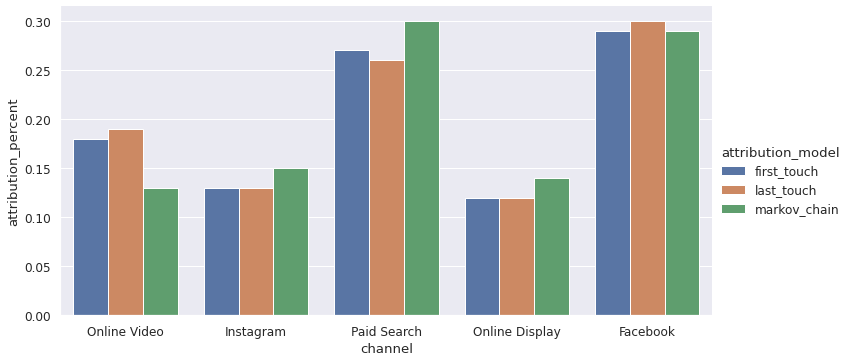

In [0]:
attribution_pd = spark.table('gold_attribution').toPandas()

sns.set(font_scale=1.1)
sns.catplot(x='channel',y='attribution_percent',hue='attribution_model',data=attribution_pd, kind='bar', aspect=2)

## 4: Spend Optimization

##### 4.1: Import libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.4)

##### 4.2: Create ad spend table

In [0]:
gold_ad_spend_tbl_path = '/FileStore/tables/goldadspendtable'

In [0]:
_ = spark.sql('''
  CREATE OR REPLACE TABLE gold_ad_spend (
    campaign_id STRING, 
    total_spend_in_dollars FLOAT, 
    channel_spend MAP<STRING, FLOAT>, 
    campaign_start_date TIMESTAMP)
  USING DELTA
  LOCATION '{}'
  '''.format(gold_ad_spend_tbl_path))

##### 4.3: Create widget for specifying the ad spend for a given campaign

In [0]:
dbutils.widgets.text("adspend", "10000", "Campaign Budget in $")

##### 4.4: Populate ad spend table with synthetic ad spend data

In [0]:
%sql
INSERT INTO TABLE gold_ad_spend
VALUES ("03d65f7e92e81480cac52a20d", $adspend,
          MAP('Facebook', .2,
              'Instagram', .2,  
              'Online Display', .2, 
              'Paid Search', .2, 
              'Online Video', .2), 
         make_timestamp(2018, 7, 31, 0, 0, 0));

num_affected_rows,num_inserted_rows
1,1


##### 4.5: View campaign ad spend details

In [0]:
%sql
SELECT * FROM gold_ad_spend

campaign_id,total_spend_in_dollars,channel_spend,campaign_start_date
03d65f7e92e81480cac52a20d,10000.0,"Map(Paid Search -> 0.2, Facebook -> 0.2, Instagram -> 0.2, Online Display -> 0.2, Online Video -> 0.2)",2018-07-31T00:00:00.000+0000


##### 4.6: Explode struct into multiple rows

In [0]:
ad_spend_df = spark.sql('select explode(channel_spend) as (channel, pct_spend), \
                         round(total_spend_in_dollars * pct_spend, 2) as dollar_spend \
                         from gold_ad_spend')

ad_spend_df.createOrReplaceTempView("exploded_gold_ad_spend")
display(ad_spend_df)

channel,pct_spend,dollar_spend
Facebook,0.2,2000.0
Instagram,0.2,2000.0
Online Display,0.2,2000.0
Paid Search,0.2,2000.0
Online Video,0.2,2000.0


##### 4.7: Base conversion rate

In [0]:
%sql
CREATE OR REPLACE TABLE base_conversion_rate
USING DELTA AS
SELECT count(*) as count,
  CASE 
    WHEN conversion == 0 
    THEN 'Impression'
    ELSE 'Conversion'
  END AS interaction_type
FROM
  gold_user_journey
GROUP BY
  conversion;

num_affected_rows,num_inserted_rows


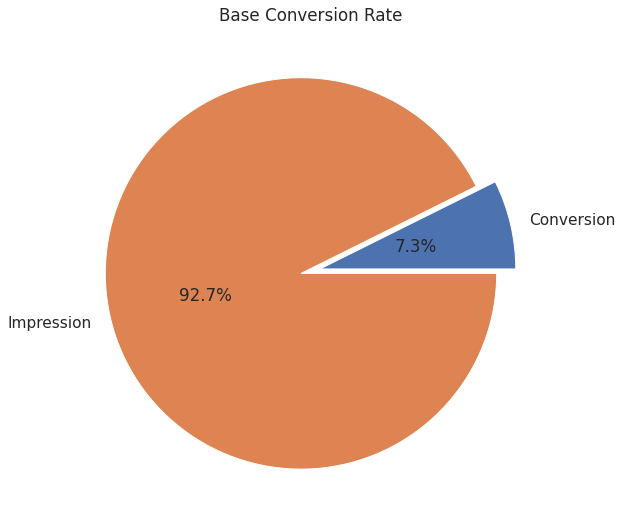

In [0]:
base_converion_rate_pd = spark.table("base_conversion_rate").toPandas()

pie, ax = plt.subplots(figsize=[20,9])
labels = base_converion_rate_pd['interaction_type']
plt.pie(x=base_converion_rate_pd['count'], autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Base Conversion Rate");

##### 4.8: Conversions by date

In [0]:
%sql
CREATE OR REPLACE TABLE conversions_by_date 
USING DELTA AS
SELECT count(*) AS count,
  'Conversion' AS interaction_type,
  date(time) AS date
FROM bronze
WHERE conversion = 1
GROUP BY date
ORDER BY date;

num_affected_rows,num_inserted_rows


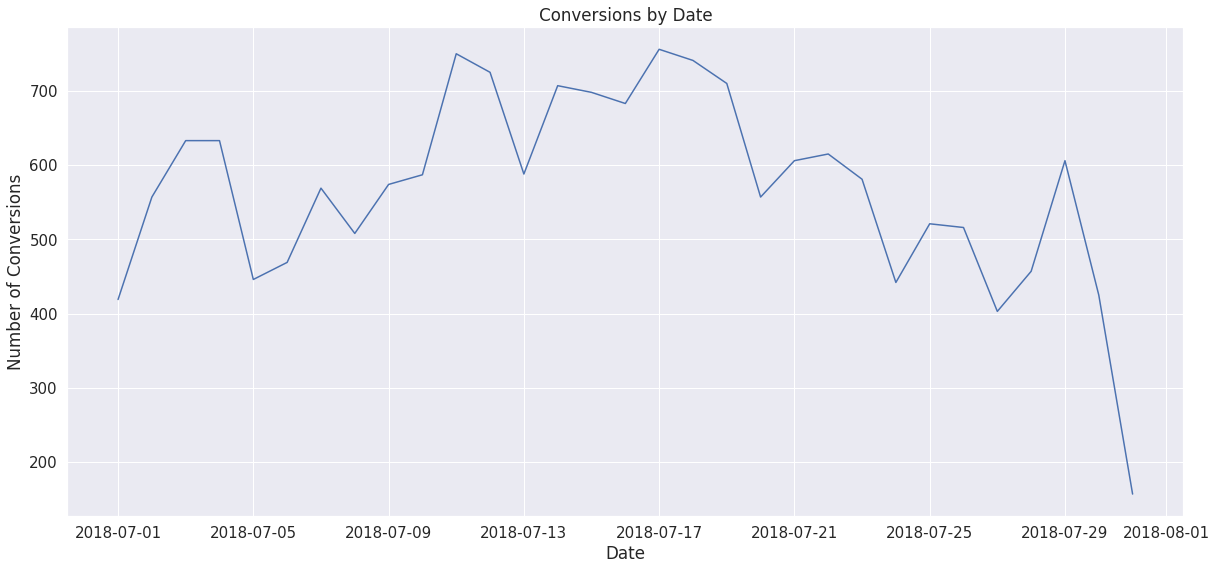

In [0]:
conversions_by_date_pd = spark.table("conversions_by_date").toPandas()

plt.figure(figsize=(20,9))
pt = sns.lineplot(x='date',y='count',data=conversions_by_date_pd)

pt.tick_params(labelsize=15)
pt.set_xlabel('Date')
pt.set_ylabel('Number of Conversions')
plt.title("Conversions by Date");

##### 4.9: Attribution by model type

In [0]:
%sql
CREATE OR REPLACE TABLE attribution_by_model_type 
USING DELTA AS
SELECT attribution_model, channel, round(attribution_percent * (
    SELECT count(*) FROM gold_user_journey WHERE conversion = 1)) AS conversions_attributed
FROM gold_attribution;

num_affected_rows,num_inserted_rows


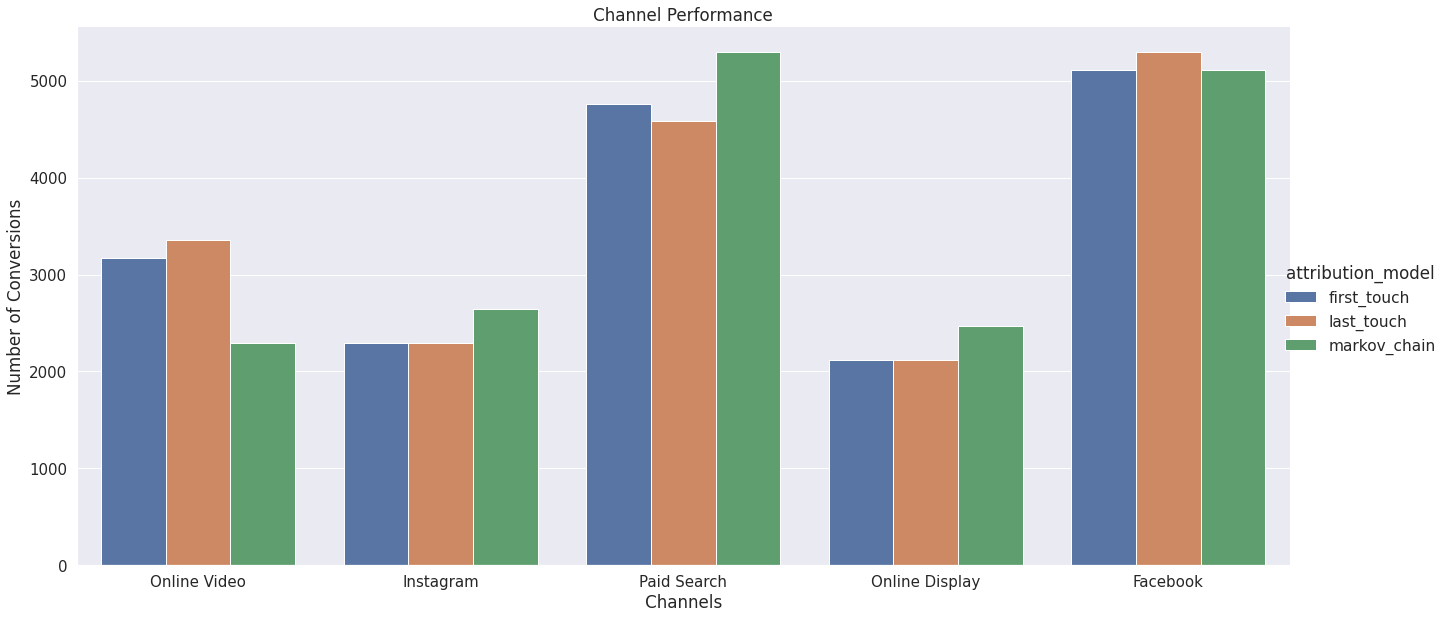

In [0]:
attribution_by_model_type_pd = spark.table("attribution_by_model_type").toPandas()

pt = sns.catplot(x='channel',y='conversions_attributed',hue='attribution_model',data=attribution_by_model_type_pd, kind='bar', aspect=4, legend=True)
pt.fig.set_figwidth(20)
pt.fig.set_figheight(9)

plt.tick_params(labelsize=15)
plt.ylabel("Number of Conversions")
plt.xlabel("Channels")
plt.title("Channel Performance");

##### 4.10: Cost per acquisition

In [0]:
%sql
CREATE OR REPLACE TABLE exploded_gold_ad_spend
USING DELTA AS
SELECT explode(channel_spend) AS (channel, spend),
   round(total_spend_in_dollars * spend, 2) AS dollar_spend
   FROM gold_ad_spend;

num_affected_rows,num_inserted_rows


In [0]:
%sql 
CREATE OR REPLACE TABLE cpa_summary 
USING DELTA AS
SELECT
  spending.channel,
  spending.dollar_spend,
  attribution_count.attribution_model,
  attribution_count.conversions_attributed,
  round(spending.dollar_spend / attribution_count.conversions_attributed,2) AS CPA_in_Dollars
FROM
  (SELECT channel, dollar_spend
   FROM exploded_gold_ad_spend) AS spending
JOIN
  (SELECT attribution_model, channel, conversions_attributed
   FROM attribution_by_model_type) AS attribution_count
ON spending.channel = attribution_count.channel;

num_affected_rows,num_inserted_rows


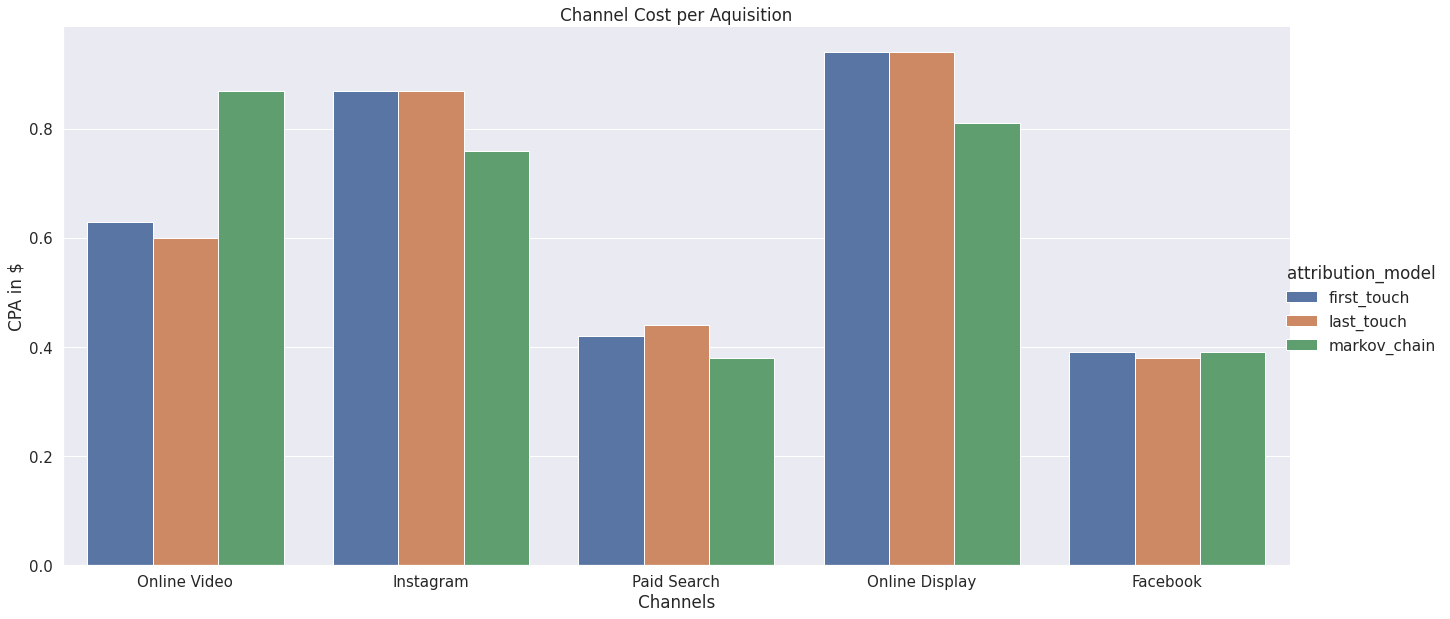

In [0]:
cpa_summary_pd = spark.table("cpa_summary").toPandas()

pt = sns.catplot(x='channel', y='CPA_in_Dollars',hue='attribution_model',data=cpa_summary_pd, kind='bar', aspect=4, ci=None)
plt.title("Cost of Aquisition by Channel")
pt.fig.set_figwidth(20)
pt.fig.set_figheight(9)

plt.tick_params(labelsize=15)
plt.ylabel("CPA in $")
plt.xlabel("Channels")
plt.title("Channel Cost per Aquisition");

##### 4.11: Budget Allocation Optimization

In [0]:
%sql
CREATE OR REPLACE TABLE spend_optimization_view 
USING DELTA
AS
SELECT
  a.channel,
  a.pct_spend,
  b.attribution_percent,
  b.attribution_percent / a.pct_spend as ROAS,
  a.dollar_spend,
  round(
    (b.attribution_percent / a.pct_spend) * a.dollar_spend,
    2
  ) as proposed_dollar_spend
FROM
  exploded_gold_ad_spend a
  JOIN gold_attribution b on a.channel = b.channel
  and attribution_model = 'markov_chain';
  
CREATE
OR REPLACE TABLE spend_optimization_final 
USING DELTA AS
SELECT
  channel,
  'current_spending' AS spending,
  dollar_spend as budget
 FROM exploded_gold_ad_spend
UNION
SELECT
  channel,
  'proposed_spending' AS spending,
  proposed_dollar_spend as budget
FROM
  spend_optimization_view;  

num_affected_rows,num_inserted_rows


Out[46]: Text(0.5, 14.143999999999991, 'Channels')

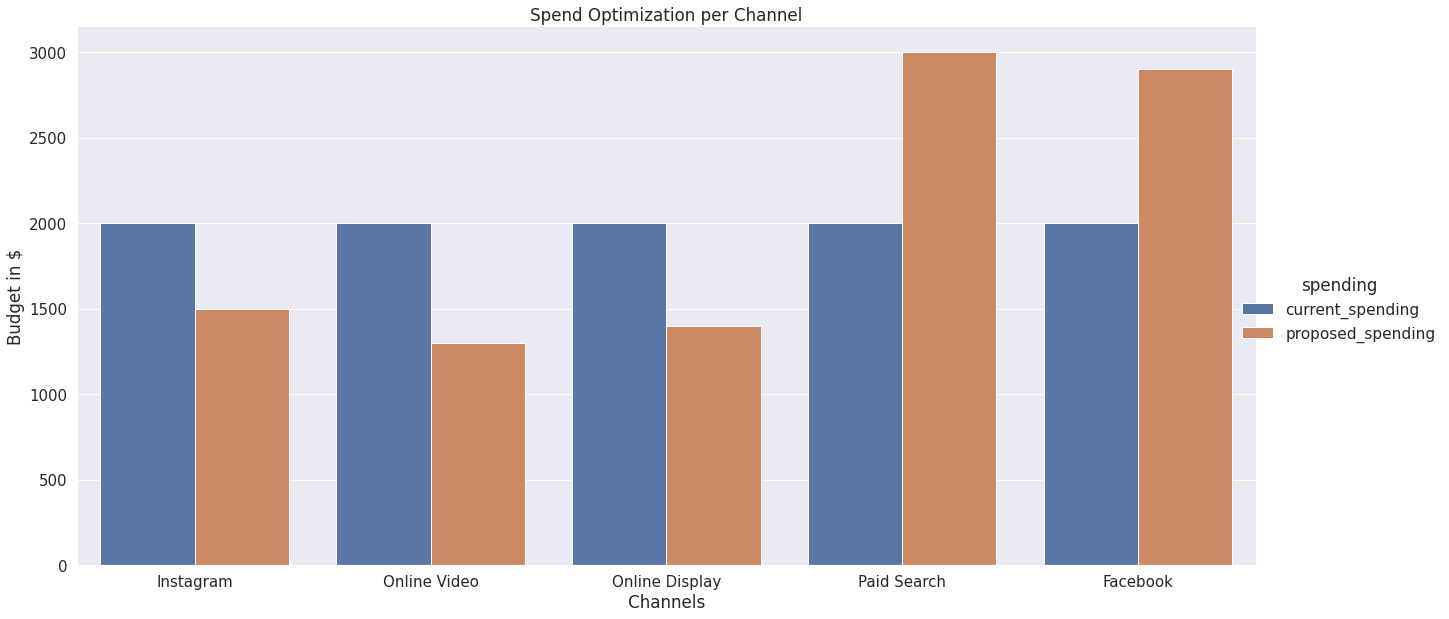

In [0]:
spend_optimization_final_pd = spark.table("spend_optimization_final").toPandas()

pt = sns.catplot(x='channel', y='budget', hue='spending', data=spend_optimization_final_pd, kind='bar', aspect=4, ci=None)

plt.tick_params(labelsize=15)
pt.fig.set_figwidth(20)
pt.fig.set_figheight(9)
plt.title("Spend Optimization per Channel")
plt.ylabel("Budget in $")
plt.xlabel("Channels")